In [2]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from rasterio.errors import RasterioIOError
import csv
from skimage import io
from pyproj import Transformer
import requests
from PIL import Image
import sys
from io import BytesIO
import kelp_tools_windows as kt

In [3]:
tile = '11SKU'
location = 'Isla_vista_kelp'
cloud_cover_threshold = .25
save_mask = True
save_classification = False
path = os.path.join(r'H:\HLS_data\imagery',location,tile)
#path = r'C:\Users\attic\HLS_Kelp\imagery\Isla_vista_kelp_2018\11SKU'
item = 'HLS.S30.T11SKU.2017297T184441.v2.0'
dem_path = r'C:\Users\attic\HLS_Kelp\imagery\Socal_DEM.tiff'
show_dem = False
use_kmeans = False

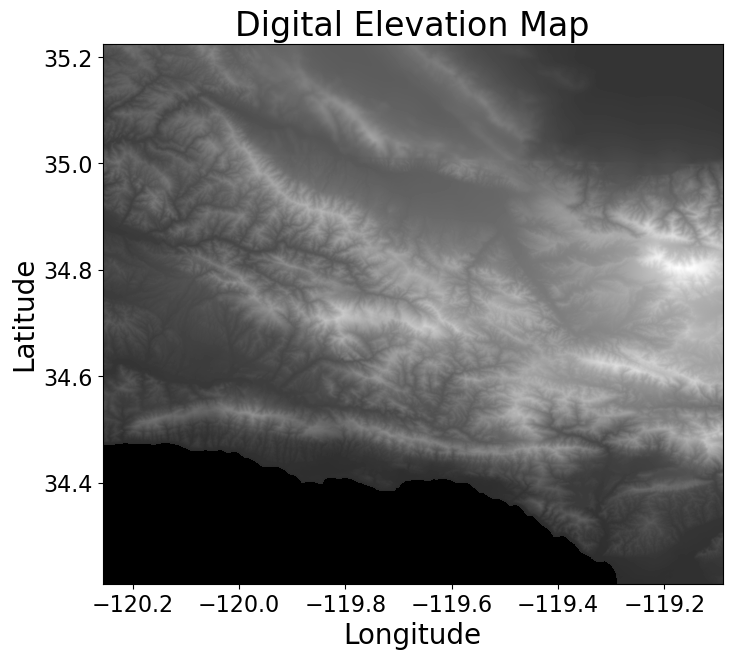

In [14]:
image_path = os.path.join(path, item)
image_files = kt.filter_and_sort_files(path,item)

geotiff_path = os.path.join(image_path, image_files[0])

land_mask = kt.create_land_mask(geotiff_path, dem_path=dem_path, show_image=show_dem)


In [ ]:
##==========Fmask Cloud mask==========##

cloud_land_mask, cloud_but_not_land_mask, percent_cloud_covered = kt.create_qa_mask(land_mask, img_path=image_path)

##==========Create stacked np array, Apply landmask==========##
img_bands = []
crs, transform = None
try:

    for file in image_files:
        with rasterio.open(os.path.join(image_path, file)) as src:
            img_bands.append(np.where(cloud_land_mask, 0, src.read(1)))  # Create image with the various bands
            if(crs is None):
                crs = src.crs
                transform = src.transform
except RasterioIOError as e:
    print(f"Error reading file {file} in granule {item}: {e}")
    sys.exit()

img = np.stack(img_bands, axis=0)
n_bands, height, width = img.shape
img_2D_normalized = kt.normalize_img(img,flatten=True)

In [ ]:
if use_kmeans:
    n_clusters_1 = 25#set this to determine number of clusters
    kmeans = KMeans(n_clusters=n_clusters_1, random_state=42)
    clusters_1 = kmeans.fit_predict(img_2D_normalized)
    kmeans_1 = clusters_1.reshape((height, width))

In [ ]:
cloud_mask_1 = np.zeros_like(kmeans_1)
clustering_1 = np.copy(kmeans_1)
clouds_land_1 = [0]#[1,2,3,4,5,7,8,9]
kelp_1 = []
ocean_1 = range(1,25)

cloud_land_mask_1 = np.isin(kmeans_1, clouds_land_1)
clustering_1[cloud_land_mask_1] = 2
kelp_mask_1 = np.isin(kmeans_1, kelp_1)
clustering_1[kelp_mask_1] = 0
ocean_mask_1 = np.isin(kmeans_1,ocean_1)
clustering_1[ocean_mask_1] = 1
clustering_1_cropped = clustering_1[2800:3200,800:1600]
kmeans_1_cropped = kmeans_1[2800:3200,800:1600]
plt.figure(figsize=(25, 25))
plt.imshow(kmeans_1_cropped,  alpha=.25)
plt.imshow(clustering_1_cropped, alpha=.75)
plt.title('clustered')
plt.colorbar()


In [ ]:
r_nor = img_2D[:,2].reshape((height, width))
g_nor = img_2D[:,1].reshape((height, width))
b_nor = img_2D[:,0].reshape((height, width))
rgb_nor = np.stack([r_nor,g_nor,b_nor], axis=-1)
#rgb_nor_cropped = rgb_nor#[2500:3400,600:2000]

rgb_cropped = rgb_nor[2800:3050,850:1600]
plt.figure(figsize=(25, 25))
plt.subplot(2, 1, 2) 
plt.imshow(rgb_cropped)
plt.title("RGB Cropped Image")
plt.show()

In [ ]:
empty_band = np.ones(len(img_2D[0,:]))*1000
kmeans_1_2D = clustering_1.reshape(-1).T
kmeans_1_landmask = np.copy(img_2D)
for i, ocean_pixel in enumerate(kmeans_1_2D):
    if not ocean_pixel == 0:
        kmeans_1_landmask[i,:] = empty_band

In [ ]:
n_clusters_2 = 10
kmeans = KMeans(n_clusters=n_clusters_2, random_state=42)
clusters_2 = kmeans.fit_predict(kmeans_1_landmask)
kmeans_2 = clusters_2.reshape((height, width))

In [ ]:
# 0 = kelp, 1 = ocean, 2 = misc (land,clouds)
cloud_mask_2 = np.zeros_like(kmeans_2)
kelp_mask_2 = np.zeros_like(kmeans_2)
misc_mask_2 = np.zeros_like(kmeans_2)

clustering_2 = np.copy(kmeans_2)
ocean_2 = []#[1,2,3,4,5,7,8,9]
misc_2 = [0]
kelp_2 = []
kelp_mask_2 = np.isin(kmeans_2, kelp_2)
clustering_2[kelp_mask_2] = 0
ocean_mask_2 = np.isin(kmeans_2, ocean_2)
clustering_2[ocean_mask_2] = 1
misc_mask_2 = np.isin(kmeans_2,misc_2)
clustering_2[misc_mask_2] = 2

clustering_2_cropped = clustering_2[2700:3400, 800:1600]
kmeans_2_cropped = kmeans_2
colors = ['red', 'green', 'blue']
cmap_custom = ListedColormap(colors)


plt.figure(figsize=(20, 10))
plt.imshow(clustering_2_cropped, alpha=.75)
plt.title('clustered')
plt.colorbar()
plt.show()

In [ ]:
if False:
    empty_band = np.zeros(len(img_2D[0,:]))
    kmeans_1_2D = clustering_2.reshape(-1).T

    kmeans_1_landmask = np.copy(img_2D)
    for i, ocean_pixel in enumerate(kmeans_1_2D):
        if not ocean_pixel == 0:
            kmeans_1_landmask[i,:] = empty_band

In [ ]:
ocean_mask = (clustering_2 == 1) | (clustering_1 == 1)
kelp_mask = (clustering_2 == 0) 
#cloud_but_not_land_mask #This is a reminder to use this pre-made mask 

combined_mask = np.full(kelp_mask.shape, 1)
combined_mask[land_mask == 1] = 3
combined_mask[cloud_but_not_land_mask == 1] = 2
combined_mask[ocean_mask == 1] = 1
combined_mask[kelp_mask == 1] = 0

plt.figure(figsize=(20, 10))
plt.imshow(combined_mask, cmap='Blues')
plt.show()

#print(combined_mask[0:20,0:20])

In [ ]:

# with rasterio.open(r"C:\Users\attic\HLS_Kelp\imagery\rf_training_v5\HLS.L30.T11SKU.2018042T183356.v2.0_kelp_classified.tif") as classified:
#            new_classified = classified.read(7)  # Create image with the various bands

In [ ]:
if save_classification:
    if not os.path.isdir (r'C:\Users\attic\HLS_Kelp\imagery\rf_training_unclassified'):
        os.mkdir(r'C:\Users\attic\HLS_Kelp\imagery\rf_training_unclassified')
    classification_path = os.path.join(r'C:\Users\attic\HLS_Kelp\imagery\rf_training_unclassified',f'{item}_kelp.tif') 
    height, width = clustering_2.shape
    reshaped_normalized_img = img_2D_normalized.reshape(height, width, 6)
    combined_img = np.dstack((reshaped_normalized_img,combined_mask))

    plt.figure(figsize=(6, 6))
    plt.imshow(combined_img[:,:,6], cmap='gray')
    plt.show()  

    num_bands = 7
    data_type = rasterio.uint8
    profile = {
        'driver': 'GTiff',
        'width': width,
        'height': height,
        'count': 7,  # one band
        'dtype': data_type,  # assuming binary mask, adjust dtype if needed
        'crs': crs,
        'transform': transform,
        'nodata': 0  # assuming no data is 0
    }
    # Write the land mask array to GeoTIFF
    with rasterio.open(classification_path, 'w', **profile) as dst:
        for i in range(num_bands):
            dst.write(combined_img[:,:,i].astype(data_type), i + 1)